<a href="https://colab.research.google.com/github/Ankur3107/nlp_notebooks/blob/master/token-classification/token_classification_transformers_zenml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install zenml -q

     |████████████████████████████████| 326 kB 29.2 MB/s 
     |████████████████████████████████| 10.1 MB 63.7 MB/s 
     |████████████████████████████████| 636 kB 63.8 MB/s 
     |████████████████████████████████| 217 kB 72.9 MB/s 
     |████████████████████████████████| 181 kB 70.0 MB/s 
     |████████████████████████████████| 10.9 MB 65.9 MB/s 
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 1.2 MB 57.0 MB/s 
     |████████████████████████████████| 151 kB 71.6 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 2.3 MB 65.6 MB/s 
     |████████████████████████████████| 508 kB 69.1 MB/s 
     |████████████████████████████████| 255 kB 77.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 40 kB 7.4 MB/s 
     |████████████████████████████████| 129 kB 63.6 MB/s 
     |████████████████

In [2]:
!pip install transformers datasets -q

     |████████████████████████████████| 3.5 MB 34.4 MB/s 
     |████████████████████████████████| 311 kB 71.4 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 70.9 MB/s 
     |████████████████████████████████| 6.8 MB 64.5 MB/s 
     |████████████████████████████████| 1.1 MB 51.1 MB/s 
     |████████████████████████████████| 133 kB 74.7 MB/s 
     |████████████████████████████████| 243 kB 72.3 MB/s 
     |████████████████████████████████| 144 kB 35.4 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 271 kB 72.8 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.36.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.


In [ ]:
!pip install mlflow

In [3]:
!git init
!zenml init

Initialized empty Git repository in /content/.git/
Initializing ZenML repository at /content.
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
Registered stack component with name 'local_orchestrator'.
Registered stack component with name 'local_metadata_store'.
Registered stack component with name 'local_artifact_store'.
Registered stack with name 'local_stack'.
ZenML repository initialized at /content.


In [1]:
ls -la

total 24
drwxr-xr-x 1 root root 4096 Feb 20 09:54 ./
drwxr-xr-x 1 root root 4096 Feb 20 09:50 ../
drwxr-xr-x 4 root root 4096 Feb  1 14:31 .config/
drwxr-xr-x 7 root root 4096 Feb 20 09:54 .git/
drwxr-xr-x 1 root root 4096 Feb  1 14:32 sample_data/
drwxr-xr-x 5 root root 4096 Feb 20 09:54 .zen/


In [2]:
import mlflow
from zenml.integrations.mlflow.mlflow_step_decorator import enable_mlflow

In [3]:
from zenml.pipelines import Schedule, pipeline
from zenml.steps import BaseStepConfig, Output, step
from datasets import load_dataset, load_metric
from datasets import Dataset
from datasets.dataset_dict import DatasetDict
import os
from typing import Any, Type
from zenml.artifacts import DataArtifact, SchemaArtifact, StatisticsArtifact, ModelArtifact
from zenml.materializers.base_materializer import BaseMaterializer

In [7]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForTokenClassification, TFDistilBertForTokenClassification
from transformers import create_optimizer
from transformers import DataCollatorForTokenClassification

In [8]:
DEFAULT_FILENAME = "dataset.parquet.gzip"
COMPRESSION_TYPE = "gzip"
DEFAULT_DICT_FILENAME = "dict_datasets"

class DatasetMaterializer(BaseMaterializer):
    """Materializer to read data to and from pandas."""

    ASSOCIATED_TYPES = (Dataset, DatasetDict)
    ASSOCIATED_ARTIFACT_TYPES = (
        DataArtifact,
    )

    def handle_input(self, data_type: Type[Any]) -> Dataset:
        """Reads Dataset from a parquet file."""
        super().handle_input(data_type)
        if issubclass(data_type, Dataset):
          return Dataset.from_parquet(
              os.path.join(self.artifact.uri, DEFAULT_FILENAME))
        elif issubclass(data_type, DatasetDict):
          return DatasetDict.load_from_disk(
              os.path.join(self.artifact.uri, DEFAULT_DICT_FILENAME)
          )

    def handle_return(self, ds: Type[Any]) -> None:
        """Writes a Dataset to the specified filename.
        Args:
            Dataset: The Dataset to write.
        """
        super().handle_return(ds)
        if isinstance(ds, Dataset):
          filepath = os.path.join(self.artifact.uri, DEFAULT_FILENAME)
          ds.to_parquet(filepath, compression=COMPRESSION_TYPE)
        elif isinstance(ds, DatasetDict):
          filepath = os.path.join(self.artifact.uri, DEFAULT_DICT_FILENAME)
          ds.save_to_disk(filepath)

In [9]:
DEFAULT_MODEL_DIR = "hf_model"

class HFModelMaterializer(BaseMaterializer):
    """Materializer to read data to and from pandas."""

    ASSOCIATED_TYPES = (TFDistilBertForTokenClassification, )
    ASSOCIATED_ARTIFACT_TYPES = (
        ModelArtifact,
    )

    def handle_input(self, data_type: Type[Any]) -> Dataset:
        """Reads Dataset from a parquet file."""
        super().handle_input(data_type)

        return TFAutoModelForTokenClassification.from_pretrained(
            os.path.join(self.artifact.uri, DEFAULT_MODEL_DIR)
        )

    def handle_return(self, model: Type[Any]) -> None:
        """Writes a Dataset to the specified filename.
        Args:
            Dataset: The Dataset to write.
        """
        super().handle_return(model)
        model.save_pretrained(os.path.join(self.artifact.uri, DEFAULT_MODEL_DIR))

In [10]:
class TokenClassificationConfig(BaseStepConfig):
  task = "ner"  # Should be one of "ner", "pos" or "chunk"
  model_checkpoint = "distilbert-base-uncased"
  batch_size = 16
  dataset_name = "conll2003"
  label_all_tokens = True
  num_train_epochs = 3

In [11]:
@step#(enable_cache=False)
def data_importer(
    config: TokenClassificationConfig,
) -> DatasetDict:
  datasets = load_dataset(config.dataset_name)
  print("Sample Example :", datasets["train"][0])
  #label_list = datasets["train"].features[f"{config.task}_tags"].feature.names
  return datasets

In [12]:
@step#(enable_cache=False)
def tokenization(
    config: TokenClassificationConfig,
    datasets: DatasetDict,
) -> DatasetDict:

  def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples[f"{config.task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if config.label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs
  tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
  tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)
  return tokenized_datasets

In [13]:
@enable_mlflow
@step#(enable_cache=False)
def trainer(
    config: TokenClassificationConfig,
    tokenized_datasets: DatasetDict,
) -> TFDistilBertForTokenClassification:
  label_list = tokenized_datasets["train"].features[f"{config.task}_tags"].feature.names
  
  model = TFAutoModelForTokenClassification.from_pretrained(
    config.model_checkpoint, num_labels=len(label_list)
  )
  
  num_train_steps = (len(tokenized_datasets["train"]) // config.batch_size) * config.num_train_epochs
  optimizer, lr_schedule = create_optimizer(
      init_lr=2e-5,
      num_train_steps=num_train_steps,
      weight_decay_rate=0.01,
      num_warmup_steps=0,
  )

  model.compile(optimizer=optimizer)

  tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
  data_collator = DataCollatorForTokenClassification(tokenizer, return_tensors="tf")

  train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=config.batch_size,
    collate_fn=data_collator,
  )
  validation_set = tokenized_datasets["validation"].to_tf_dataset(
      columns=["attention_mask", "input_ids", "labels"],
      shuffle=False,
      batch_size=config.batch_size,
      collate_fn=data_collator,
  )

  mlflow.tensorflow.autolog()
  model.fit(
    train_set,
    #validation_data=validation_set,
    epochs=config.num_train_epochs
  )
  return model

In [14]:
import tensorflow as tf

@enable_mlflow
@step#(enable_cache=False)
def evaluator(
    config: TokenClassificationConfig,
    model: TFDistilBertForTokenClassification,
    tokenized_datasets: DatasetDict,
) -> float:
  tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint)
  data_collator = DataCollatorForTokenClassification(tokenizer, return_tensors="tf")
  model.compile(optimizer=tf.keras.optimizers.Adam())
  validation_set = tokenized_datasets["validation"].to_tf_dataset(
      columns=["attention_mask", "input_ids", "labels"],
      shuffle=False,
      batch_size=config.batch_size,
      collate_fn=data_collator,
  )
  test_loss = model.evaluate(validation_set, verbose=1)
  mlflow.log_metric("val_loss", test_loss)
  return test_loss

In [15]:
@pipeline#(enable_cache=False)
def train_pipeline(importer, tokenizer, trainer):
  datasets = importer()
  tokenized_datasets = tokenizer(datasets=datasets)
  model = trainer(tokenized_datasets)

In [41]:
#train_pipeline(importer=data_importer().with_return_materializers(DatasetMaterializer),
#                       tokenizer=tokenization().with_return_materializers(DatasetMaterializer),
#               trainer=trainer().with_return_materializers(HFModelMaterializer)).run()

Creating run for pipeline: `train_pipeline`
Cache enabled for pipeline `train_pipeline`
Using stack `local_stack` to run pipeline `train_pipeline`...
Step `data_importer` has started.
Step `data_importer` has finished in 0.043s.
Step `tokenization` has started.
Step `tokenization` has finished in 0.035s.
Step `trainer` has started.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

10/10 [==============================] - 34s 2s/step - loss: 1.6988
Step `trainer` has finished in 56.223s.
Pipeline run `train_pipeline-20_Feb_22-07_02_06_772016` has finished in 56.331s.


In [16]:
@pipeline#(enable_cache=False)
def train_eval_pipeline(importer, tokenizer, trainer, evaluator):
  datasets = importer()
  tokenized_datasets = tokenizer(datasets=datasets)
  model = trainer(tokenized_datasets)
  evaluator(model=model, tokenized_datasets=tokenized_datasets)

In [17]:
train_eval_pipeline(importer=data_importer().with_return_materializers(DatasetMaterializer),
                       tokenizer=tokenization().with_return_materializers(DatasetMaterializer),
               trainer=trainer().with_return_materializers(HFModelMaterializer),
               evaluator=evaluator()).run()

Creating run for pipeline: `train_eval_pipeline`
Cache enabled for pipeline `train_eval_pipeline`
Using stack `local_stack` to run pipeline `train_eval_pipeline`...
Step `data_importer` has started.


Downloading:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/983k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

INFO:datasets_modules.datasets.conll2003.63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee.conll2003:⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/extracted/fb350f14aaa0ce8a148eb2de9b8f4c19422485ca2524f6b4170579a4759a2d51/train.txt


0 examples [00:00, ? examples/s]

INFO:datasets_modules.datasets.conll2003.63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee.conll2003:⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/extracted/fb350f14aaa0ce8a148eb2de9b8f4c19422485ca2524f6b4170579a4759a2d51/valid.txt


0 examples [00:00, ? examples/s]

INFO:datasets_modules.datasets.conll2003.63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee.conll2003:⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/extracted/fb350f14aaa0ce8a148eb2de9b8f4c19422485ca2524f6b4170579a4759a2d51/test.txt


Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Sample Example : {'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
Step `data_importer` has finished in 7.227s.
Step `tokenization` has started.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Step `tokenization` has finished in 4.195s.
Step `trainer` has started.


2022/02/20 09:58:49 INFO mlflow.tracking.fluent: Experiment with name 'train_eval_pipeline' does not exist. Creating a new experiment.


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Using `-1` to mask the loss for the token is deprecated. Please use `-100` instead.
  return py_builtins.overload_of(f)(*args)


  6/877 [..............................] - ETA: 1:45 - loss: 1.7235

877/877 [==============================] - 102s 102ms/step - loss: 0.1888
Epoch 2/3
877/877 [==============================] - 92s 104ms/step - loss: 0.0539
Epoch 3/3
877/877 [==============================] - 92s 105ms/step - loss: 0.0345


2022/02/20 10:05:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to save the object {'loss': <function dummy_loss at 0x7f487b607b90>, 'logits': None} (a dictionary wrapper constructed automatically on attribute assignment). The wrapped dictionary was modified outside the wrapper (its final value was {'loss': <function dummy_loss at 0x7f487b607b90>, 'logits': None}, its value when a checkpoint dependency was added was None), which breaks restoration on object creation.

If you don't need this dictionary checkpointed, wrap it in a non-trackable object; it will be subsequently ignored.


Step `trainer` has finished in 7m31s.
Step `evaluator` has started.


Some layers from the model checkpoint at /root/.config/zenml/local_stores/4f1f1248-e71b-4ac6-ac34-396be78aa2b2/trainer/output/3/hf_model were not used when initializing TFDistilBertForTokenClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at /root/.config/zenml/local_stores/4f1f1248-e71b-4ac6-ac34-396be78aa2b2/trainer/output/3/hf_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on

204/204 [==============================] - 9s 33ms/step - loss: 0.0587
Step `evaluator` has finished in 10.280s.
Pipeline run `train_eval_pipeline-20_Feb_22-09_58_38_115601` has finished in 7m53s.


In [23]:
#train_pipeline(importer=data_importer().with_return_materializers(DatasetMaterializer),
#                       tokenizer=tokenization().with_return_materializers(DatasetMaterializer),
#               trainer=trainer()).run()

Creating run for pipeline: `train_pipeline`
Cache enabled for pipeline `train_pipeline`
Using stack `local_stack` to run pipeline `train_pipeline`...
Step `data_importer` has started.
Step `data_importer` has finished in 0.041s.
Step `tokenization` has started.
Step `tokenization` has finished in 0.041s.
Step `trainer` has started.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

10/10 [==============================] - 31s 2s/step - loss: 1.7103
Step `trainer` has finished in 53.341s.
Pipeline run `train_pipeline-20_Feb_22-06_23_52_536912` has finished in 53.457s.


# Install localtunnel

In [ ]:
!npm install -g localtunnel

# lineage

In [ ]:
!zenml integration install dash -f

In [33]:
%%writefile run_lineage.py

from zenml.integrations.dash.visualizers.pipeline_run_lineage_visualizer import (
    PipelineRunLineageVisualizer,
)
from zenml.repository import Repository

repo = Repository()
latest_run = repo.get_pipelines()[-1].runs[-1]
print(latest_run)
PipelineRunLineageVisualizer().visualize(latest_run)

Writing run_lineage.py


In [35]:
!python run_lineage.py & lt --port 8050

your url is: https://wonderful-seahorse-55.loca.lt
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
PipelineRunView(id=2, name='train_eval_pipeline-20_Feb_22-09_58_38_115601')
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "zenml.integrations.dash.visualizers.pipeline_run_lineage_visualizer" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
INFO:werkzeug: * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [20/Feb/2022 10:19:44] "GET /favicon.ico HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2022 10:19:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2022 10:19:44] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_2_0m1645352095.12.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2022 10:19:44] "GET /_dash-component-suites/dash/deps/react@16.v2_2_0m1645352095.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127

KeyboardInterrupt: ignored

# MlFlow Tracking

In [18]:
from zenml.environment import Environment
from zenml.integrations.mlflow.mlflow_environment import MLFLOW_ENVIRONMENT_NAME

In [19]:
mlflow_env = Environment()[MLFLOW_ENVIRONMENT_NAME]
mlflow_env

In [20]:
mlflow_env.tracking_uri

'file:/root/.config/zenml/local_stores/4f1f1248-e71b-4ac6-ac34-396be78aa2b2/mlruns'

In [36]:
!mlflow ui --backend-store-uri {mlflow_env.tracking_uri} & lt --port 5000

your url is: https://honest-wasp-2.loca.lt
[2022-02-20 10:23:21 +0000] [840] [INFO] Starting gunicorn 20.1.0
[2022-02-20 10:23:21 +0000] [840] [INFO] Listening at: http://127.0.0.1:5000 (840)
[2022-02-20 10:23:21 +0000] [840] [INFO] Using worker: sync
[2022-02-20 10:23:21 +0000] [843] [INFO] Booting worker with pid: 843
[2022-02-20 10:23:52 +0000] [840] [CRITICAL] WORKER TIMEOUT (pid:843)
[2022-02-20 10:23:52 +0000] [843] [INFO] Worker exiting (pid: 843)
[2022-02-20 10:23:52 +0000] [850] [INFO] Booting worker with pid: 850
[2022-02-20 10:25:06 +0000] [840] [INFO] Handling signal: int
[2022-02-20 10:25:06 +0000] [850] [INFO] Worker exiting (pid: 850)
[2022-02-20 10:25:06 +0000] [840] [INFO] Shutting down: Master
^C


# Dag Visualization

In [37]:
!zenml integration install graphviz -f

     |████████████████████████████████| 46 kB 4.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [41]:
from zenml.repository import Repository
from zenml.integrations.graphviz.visualizers.pipeline_run_dag_visualizer import (
    PipelineRunDagVisualizer,
)

In [39]:
repo = Repository()
pipe = repo.get_pipelines()[-1]
latest_run = pipe.runs[-1]
latest_run

PipelineRunView(id=2, name='train_eval_pipeline-20_Feb_22-09_58_38_115601')

This integration is not completed yet. Results might be unexpected.


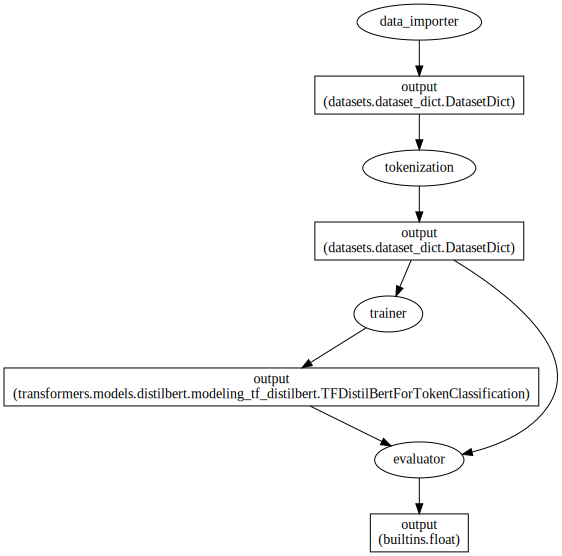

In [40]:
PipelineRunDagVisualizer().visualize(latest_run)